In [2]:
from helpers_merging import *

initial_power = 50* si.uW
initial_waist = 1.1*si.uW
initial_distance = 3*si.um

trap: DoubleTweezer = DoubleTweezer(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0*si.G/si.cm,
    grad_r=0,
    power_tweezer1 = initial_power,     #stationary
    power_tweezer2 = initial_power,     #transfer tweezer
    waist_tweezer1 = initial_waist,     #stationary
    waist_tweezer2 = initial_waist*1.075,     #transfer tweezer
    distance_tweezers = initial_distance,

    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    wvl = 532 * si.nm,

    g = 0,
)

x, y, z = trap.x, trap.y, trap.z

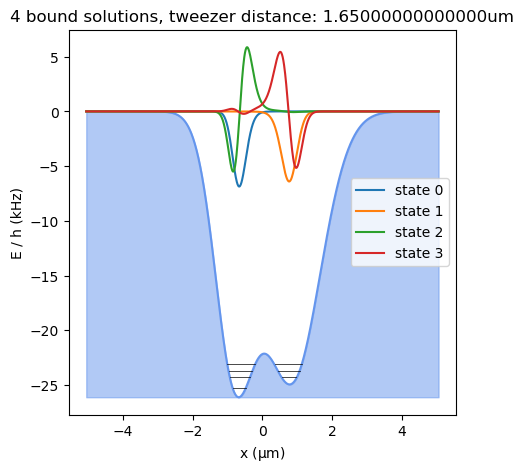

In [3]:
left_cutoff = -0.5*initial_distance-3*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
right_cutoff = 0.5*initial_distance+3*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])

trap[trap.distance_tweezers] = 0.55*initial_distance
trap[trap.power_tweezer2] = initial_power*2.5
trap[trap.waist_tweezer2] = initial_waist*1.5
plot_solutions(trap,4,left_cutoff,right_cutoff,display_plot=-1,state_mult=40,n_pot_steps=1000,plot=True,ret_results=False)

In [12]:
def get_deltaE(power_tweezer1, power_tweezer2, waist_tweezer1, waist_tweezer2, fac,
               n_levels=10,n_pot_steps=2000, initial_distance=4*si.um, plot=True):
    """
    Returns the minimal energy gap and occupation numbers of the groundstate when the two tweezers merge.
    """
    trap[trap.power_tweezer1] = power_tweezer1
    trap[trap.power_tweezer2] = power_tweezer2
    trap[trap.waist_tweezer1] = waist_tweezer1
    trap[trap.waist_tweezer2] = waist_tweezer2

    distances = np.linspace(initial_distance,0*si.um,500) #always has to have smallest distance at last index
    energies, states, potentials = loop_distances(trap, distances,n_levels=n_levels,n_pot_steps=n_pot_steps)

    new_energies, new_states, new_potentials, index_top, index, swap_index = swapped_loop_distance(distances, energies, states, potentials)
    energies_left, energies_right, states_left, states_right = find_ass_tweezer(new_energies,new_states, return_deltaE=False)

    if len(index)!=0:
        deltaE_min = 0
        print("crossover")
    else:
        deltaE_min = np.inf
        for i in range(energies_left.shape[1]):
            for j in range(energies_right.shape[1]):
                row_diff = np.nanmin(np.abs(energies_left[:,i] - energies_right[:,j]))
                if row_diff<deltaE_min:
                    deltaE_min = row_diff
                    i_min, j_min = i,j
        print(f"closest approach between states: left:{i_min}, right:{j_min}")

    if plot:
        # Create the figure with two subplots (1 row, 2 columns)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        # Plot the full range on ax1
        """
        ax1.plot(distances/si.um, energies_left[:, 0], color="red", label="GS left tweezer")
        ax1.plot(distances/si.um, energies_right[:, 0], color="blue", label="GS right tweezer")
        ax1.plot(distances/si.um, energies_left[:, 1:], color="red", linestyle="dotted", label="left tweezer")
        ax1.plot(distances/si.um, energies_right[:, 1:], color="blue", linestyle="dotted", label="right tweezer")"""
        ax1.plot(distances/si.um, energies_left[:]/const.h/1e3, color="red", label="left tweezer")
        ax1.plot(distances/si.um, energies_right[:]/const.h/1e3, color="blue", label="right tweezer")

        for i, ind in enumerate(index):
            ax1.axvline(distances[ind]/si.um, color="k", alpha=0.7, label="energy crossings")

        ax1.set_xlabel("Tweezer distance [um]")
        ax1.set_ylabel("Eigenenergy/h [kHz]")
        #ax1.set_title(fr"$p_l={float(trap.subs(trap.power_tweezer1))/si.uW:.1f}$ uW, $p_r={float(trap.subs(trap.power_tweezer2))/si.uW:.1f}$ uW, $w_l={float(trap.subs(trap.waist_tweezer1))/si.um:.3f}$ um, $w_r={float(trap.subs(trap.waist_tweezer2))/si.um:.3f}$ um")
        ax1.set_title(fr"$V_r - V_l = {fac}\cdot \hbar\omega_l$")
        ax1.grid()

        # Plot the zoomed-in range (1 to 1.5 µm) on ax2
        """
        ax2.plot(distances/si.um, energies_left[:, 0], color="red", label="GS left tweezer")
        ax2.plot(distances/si.um, energies_right[:, 0], color="blue", label="GS right tweezer")
        ax2.plot(distances/si.um, energies_left[:, 1:], color="red", linestyle="dotted", label="left tweezer")
        ax2.plot(distances/si.um, energies_right[:, 1:], color="blue", linestyle="dotted", label="right tweezer")"""
        ax2.plot(distances/si.um, energies_left[:]/const.h/1e3, color="red", label="left tweezer")
        ax2.plot(distances/si.um, energies_right[:]/const.h/1e3, color="blue", label="right tweezer")

        for i, ind in enumerate(index):
            ax2.axvline(distances[ind]/si.um, color="k", alpha=0.7, label="level crossing")

        ax2.set_xlabel("Tweezer distance [um]")
        ax2.set_ylabel("Eigenenergy/h [kHz]")
        ax2.set_title("Zoomed-in Region")
        ax2.set_xlim(0.9, 1.9)  # Zooming in on the region between 1.0 and 1.5 µm
        ax2.set_ylim(-28,-13)
        ax2.grid()

        # Remove duplicates in the legend (labels that appear in both subplots)
        handles, labels = ax1.get_legend_handles_labels()
        unique_labels = dict(zip(labels, handles))  # Remove duplicates
        ax1.legend(unique_labels.values(), unique_labels.keys())

        # Show the plots
        plt.tight_layout()
        plt.savefig("ferm_.png",dpi=300)
        plt.show()

    return deltaE_min

crossover


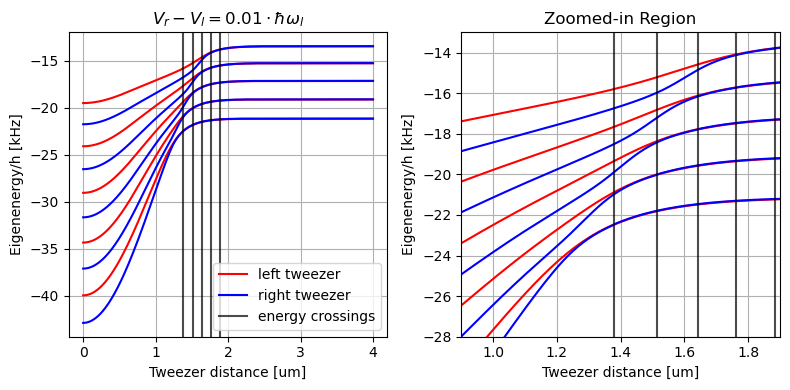

0


In [16]:
factor_waist2 = 1.
fac = 0.01

trap[trap.power_tweezer1] = initial_power
trap[trap.waist_tweezer1] = initial_waist
trap[trap.waist_tweezer2] = initial_waist*factor_waist2

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2
omega_r2 = sp.sqrt(2*trap.power_tweezer2*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer2**2

#offset required for 1 level spacing of the left tweezer
power2_offset = sp.pi*trap.waist_tweezer1**2*const.hbar*omega_r1/2/trap.a

#factor to match trap depth and offset by half(or another fraction of) the level spacing
power2_factor = factor_waist2**2 - fac*float(trap.subs(power2_offset))/initial_power

deltaEs = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2, fac=fac,n_levels=10)

print(deltaEs)

2126.4779442798836
closest approach between states: left:1, right:0


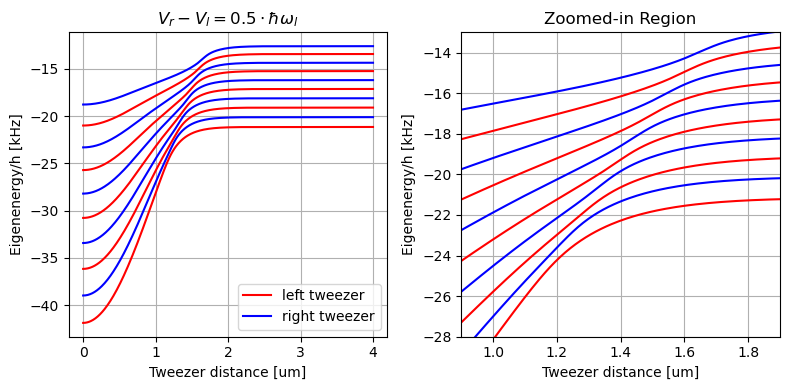

3.2369169874680074e-31


In [17]:
factor_waist2 = 1.
fac = 0.5

trap[trap.power_tweezer1] = initial_power
trap[trap.waist_tweezer1] = initial_waist
trap[trap.waist_tweezer2] = initial_waist*factor_waist2

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2
omega_r2 = sp.sqrt(2*trap.power_tweezer2*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer2**2
print(float(trap.subs(omega_r1))/2/np.pi)

#offset required for 1 level spacing of the left tweezer
power2_offset = sp.pi*trap.waist_tweezer1**2*const.hbar*omega_r1/2/trap.a

#factor to match trap depth and offset by half(or another fraction of) the level spacing
power2_factor = factor_waist2**2 - fac*float(trap.subs(power2_offset))/initial_power

deltaEs = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2, fac=fac,n_levels=10)

print(deltaEs)

crossover


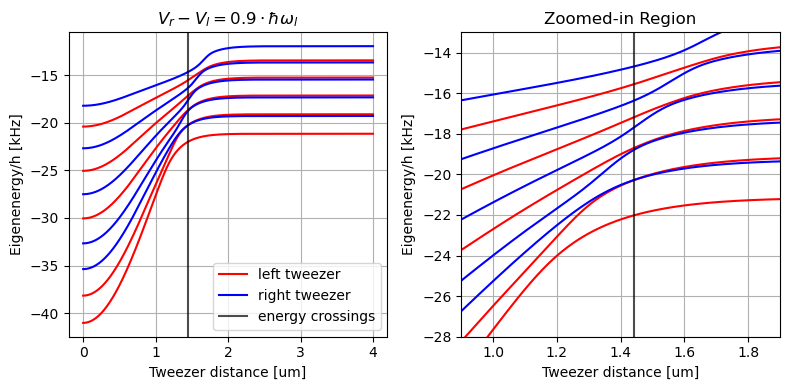

0


In [14]:
factor_waist2 = 1.
fac = 0.9

trap[trap.power_tweezer1] = initial_power
trap[trap.waist_tweezer1] = initial_waist
trap[trap.waist_tweezer2] = initial_waist*factor_waist2

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2
omega_r2 = sp.sqrt(2*trap.power_tweezer2*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer2**2

#offset required for 1 level spacing of the left tweezer
power2_offset = sp.pi*trap.waist_tweezer1**2*const.hbar*omega_r1/2/trap.a

#factor to match trap depth and offset by half(or another fraction of) the level spacing
power2_factor = factor_waist2**2 - fac*float(trap.subs(power2_offset))/initial_power

deltaEs = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2, fac=fac,n_levels=10)

print(deltaEs)